<a href="https://colab.research.google.com/github/okada-t-rafael/pytorch_study/blob/master/02_pytorch_classification_exercises_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from torch import nn

## 1. Make classification data

In [2]:
# Create dataset
N = 100
D = 2
K = 3
X = np.zeros((N * K, D))
y = np.zeros(N * K, dtype='uint8')
for j in range(K):
    ix = range(N * j, N * (j + 1))
    r = np.linspace(0.0, 1, N)
    t = np.linspace(j * 4, (j + 1) * 4, N) + np.random.randn(N) * 0.2
    X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
    y[ix] = j

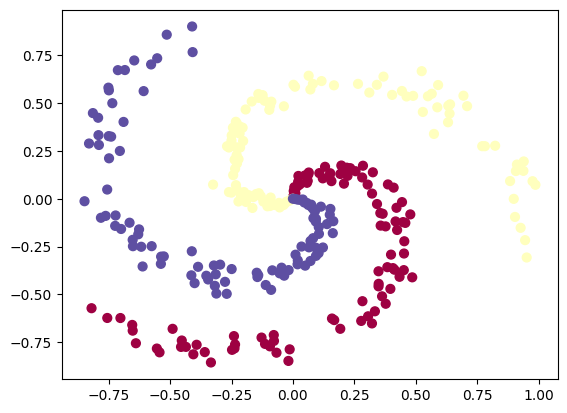

In [3]:
# Visualize dataset
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [4]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

In [5]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Check sizes
len(X_train), len(y_train), len(X_test), len(y_test)

(240, 240, 60, 60)

## 2. Building a model

In [7]:
# Make deice agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [8]:
# Put data on the target device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

In [9]:
# Build a classification model
class SpiralModel(nn.Module):
    def __init__(
        self,
        input_features: int,
        output_features: int,
        hidden_units: int=5
        ) -> None:

        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer_stack(x)

In [10]:
model_0 = SpiralModel(
    input_features=2,
    output_features=3,
    hidden_units=16).to(device)

In [11]:
model_0

SpiralModel(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=3, bias=True)
  )
)

## 3. Setup Loss function and Optimizer

In [12]:
# Create a loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer for multi-class classification
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [13]:
# Define accuracy function
def acc_fn(y_true: torch.Tensor, y_pred: torch.Tensor) -> float:
    correct = torch.eq(y_true, y_pred).sum().item()
    return (correct / len(y_pred)) * 100

## 4. Building a training and testing loop

In [14]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1200

# Building training and evaulation loop
for epoch in range(epochs):
    # Training
    model_0.train()

    # Forward pass
    y_logits = model_0(X_train)
    y_pred_prob = torch.softmax(y_logits, dim=1)
    y_pred = torch.argmax(y_pred_prob, dim=1)

    # Calculate loss/acc
    loss = loss_fn(y_logits, y_train)
    acc = acc_fn(y_true=y_train, y_pred=y_pred)

    # Optimizer zero grad
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()

    # Gradient descent
    optimizer.step()

    # Testing
    model_0.eval()
    with torch.inference_mode():
        # Forward pass
        test_logits = model_0(X_test)
        test_pred_prob = torch.softmax(test_logits, dim=1)
        test_pred = torch.argmax(test_pred_prob, dim=1)

        # Calculate loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = acc_fn(y_true=y_test, y_pred=test_pred)

    # Print out what's happenin'
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.09815, Acc: 38.33% | Test loss: 1.10221, Test acc: 31.67%
Epoch: 100 | Loss: 0.99021, Acc: 53.75% | Test loss: 1.02512, Test acc: 41.67%
Epoch: 200 | Loss: 0.78325, Acc: 56.67% | Test loss: 0.82679, Test acc: 50.00%
Epoch: 300 | Loss: 0.61170, Acc: 64.17% | Test loss: 0.67736, Test acc: 55.00%
Epoch: 400 | Loss: 0.51057, Acc: 72.08% | Test loss: 0.56448, Test acc: 66.67%
Epoch: 500 | Loss: 0.45637, Acc: 80.42% | Test loss: 0.53370, Test acc: 75.00%
Epoch: 600 | Loss: 0.33524, Acc: 85.83% | Test loss: 0.35563, Test acc: 83.33%
Epoch: 700 | Loss: 0.23386, Acc: 91.67% | Test loss: 0.21961, Test acc: 91.67%
Epoch: 800 | Loss: 0.15689, Acc: 93.33% | Test loss: 0.13882, Test acc: 96.67%
Epoch: 900 | Loss: 0.11337, Acc: 95.00% | Test loss: 0.10346, Test acc: 98.33%
Epoch: 1000 | Loss: 0.08972, Acc: 95.83% | Test loss: 0.08062, Test acc: 98.33%
Epoch: 1100 | Loss: 0.07769, Acc: 95.83% | Test loss: 0.06779, Test acc: 98.33%


In [15]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Download helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")

    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

Download helper_functions.py


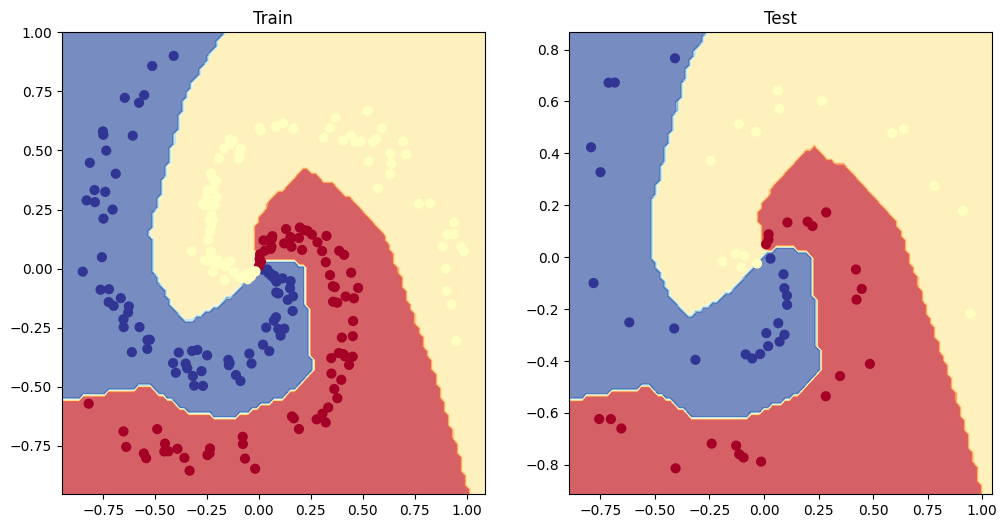

In [16]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)